# Wake Models

A wake model in FLORIS is made up of four components that together constitute a wake.
At minimum, the velocity deficit profile behind a wind turbine is required. For most models,
an additional wake deflection model is included to model the effect of yaw misalignment.
Turbulence models are also available to couple with the deficit and deflection components.
Finally, methods for combining wakes with the rest of the flow field are available.

Computationally, the solver algorithm and grid-type supported by each wake model can also
be considered as part of the model itself. As shown in the diagram below, the mathematical
formulations can be considered as the main components of the model. These are typically
associated directly to each other and in some cases they are bundled together into
a single mathematical formulation. The solver algorithm and grid type are associated
to the math formulation, but they are typically more generic.

```{mermaid}
flowchart LR
    A["Deficit"]
    B["Deflection"]
    C["Turbulence"]
    D["Velocity"]
    E["Solver"]
    F["Grid"]

    subgraph H[FLORIS Wake Model]
        direction LR
        subgraph G[Math Model]
            direction LR
            A---B
            B---C
            C---D
        end
        G---E
        E---F
    end
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from floris.tools import FlorisInterface
import floris.tools.visualization as wakeviz

## Velocity deficit

The velocity deficit models describe the velocity profile behind a wind turbine as a function of
distance from the turbine plus additional model-specific parameters.

### Jensen
The Jensen model computes the wake velocity deficit based on the classic Jensen/Park model
{cite:t}`jensen1983note`. It is often refered to as a "top-hat" model because the spanwise
velocity profile is constant across the wake and abruptly jumps to freestream outside of the
wake boundary line. The plot below shows the profile of the wake deficit. The grid is
intentionally coarse to highlight the streamwise linearity of this model. The slope of
the wake boundary line, or wake expansion, is a user parameter.

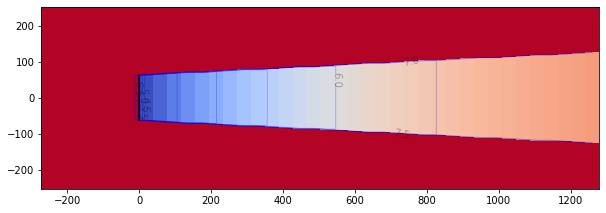

In [2]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
fi = FlorisInterface("../examples/inputs/jensen.yaml")
fi.reinitialize(layout_x=np.array([0.0]), layout_y=np.array([0.0]))
horizontal_plane = fi.calculate_horizontal_plane(
    height=90.0,
    x_resolution=40,
)
wakeviz.visualize_cut_plane(horizontal_plane, ax=axes)
wakeviz.plot_turbines_with_fi(fi, ax=axes)

### Gauss and GCH
The Gaussian velocity model is implemented based on {cite:t}`bastankhah2016experimental` and
{cite:t}`niayifar2016analytical`. This model represents the velocity deficity as a gaussian
distribution in the spanwise direction, and the gaussian profile is controlled by user parameters.
There is a near wake zone and a far wake zone. Both maintain the gaussian profile in the spanwise
direction, but they have different models for wake recovery. 

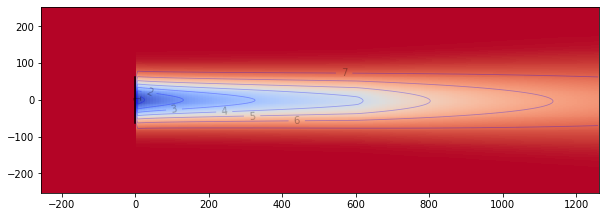

In [3]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
fi = FlorisInterface("../examples/inputs/gch.yaml")
fi.reinitialize(layout_x=np.array([0.0]), layout_y=np.array([0.0]))
horizontal_plane = fi.calculate_horizontal_plane(
    height=90.0,
    x_resolution=200,
)
wakeviz.visualize_cut_plane(horizontal_plane, ax=axes)
wakeviz.plot_turbines_with_fi(fi, ax=axes)

### Cumulative Curl
The cumulative curl model is an implementation of the model described in {cite:t}`bay_2022`,
which itself is based on the cumulative model of {cite:t}`bastankhah_2021`

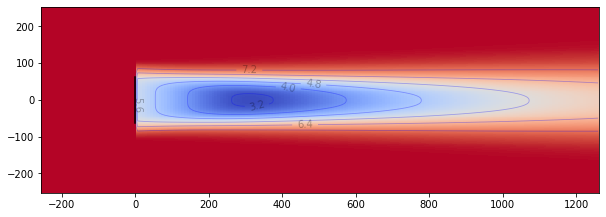

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
fi = FlorisInterface("../examples/inputs/cc.yaml")
fi.reinitialize(layout_x=np.array([0.0]), layout_y=np.array([0.0]))
horizontal_plane = fi.calculate_horizontal_plane(
    height=90.0,
    x_resolution=200,
)
wakeviz.visualize_cut_plane(horizontal_plane, ax=axes)
wakeviz.plot_turbines_with_fi(fi, ax=axes)

### TurbOPark
Model based on the TurbOPark model. For model details see https://github.com/OrstedRD/TurbOPark,
https://github.com/OrstedRD/TurbOPark/blob/main/TurbOPark%20description.pdf, and Nygaard, Nicolai
Gayle, et al. "Modelling cluster wakes and wind farm blockage." 2020.

## Wake deflection


### Jimenez
Jiménez wake deflection model, derived from {cite:t}`jimenez2010application`.

### Gauss and GCH
The Gauss deflection model is a blend of the models described in
{cite:t}`bastankhah2016experimental` and {cite:t}`King2019Controls` for calculating
the deflection field in turbine wakes.


## Turbulence

### Crespo-Hernandez

CrespoHernandez is a wake-turbulence model that is used to compute additional variability introduced
to the flow field by operation of a wind turbine. Implementation of the model follows the original
formulation and limitations outlined in {cite:t}`crespo1996turbulence`.


## Wake combination

### FLS

FLS uses freestream linear superposition to apply the wake velocity deficits to the freestream
flow field.

### MAX

MAX uses the maximum wake velocity deficit to add to the base flow field. For more information,
refer to {cite:t}`gunn2016limitations`.

### SOSFS

SOSFS uses sum of squares freestream superposition to combine the wake velocity deficits to the base
flow field.

### Shorthand Model Naming

#### Jensen

The Jensen model uses the Jensen velocity model, Jimenez deflection model, CrespoHernandez
turbulence model, and SOSFS combination model.

#### GCH

The Gauss-Curl-Hybrid model combines Gaussian wake models to capture second-order effects of wake
steering using curl-based methods, as described in {cite:t}`King2019Controls`

#### CC

The CC model uses the Cumulative Curl velocity model, CrespoHernandez turbulence model, the Gaussian
deflection model, and the SOSFS combination model.

## Model Setup

Here, we'll define a method to consistently calculate the varying cut planes for plotting later on.
We'll also set up each of the three models that we'll compare to highlight the differences in how
they operate.

In [4]:
def get_plot_parameters(fi):
    """Calculates the horizontal, streamwise, and rotor planes for a given FlorisInterface (fi)
    object.
    """

    horizontal_plane = fi.calculate_horizontal_plane(
        x_resolution=200,
        y_resolution=100,
        height=90.0,
        yaw_angles=np.array([[[25.,0.,0., 25.,0.,0., 25.,0.,0.]]]),
    )
    y_plane = fi.calculate_y_plane(
        x_resolution=200,
        z_resolution=100,
        crossstream_dist=630.0,
        # yaw_angles=np.array([[[25.,0.,0.],[25.,0.,0.],[25.,0.,0.]]]),
    )
    cross_plane = fi.calculate_cross_plane(
        y_resolution=100,
        z_resolution=100,
        downstream_dist=630.0,
        # yaw_angles=np.array([[[50.,0.,0.],[50.,0.,0.],[50.,0.,0.]]]),
    )
    return horizontal_plane, y_plane, cross_plane

# Use a more granular grid than the default
# Note: only a 3x3 rotor grid can be initialized
solver_settings = {
    "type": "turbine_grid",
    "turbine_grid_points": 10
}

# Update the layout to be a staggered 3x3 turbine grid
layout_x = np.arange(3) * np.ones((3, 3)) * 700
layout_x[1] += 250
layout_x[2] += 500
layout_x = layout_x.flatten()

layout_y = (np.arange(0, 601, 300).reshape(-1, 1) * np.ones((3, 3))).flatten()

# Define each of the CC, GCH, and Jensen models
fi_cc = FlorisInterface("../examples/inputs/cc.yaml")
fi_gch = FlorisInterface("../examples/inputs/gch.yaml")
fi_jensen = FlorisInterface("../examples/inputs/jensen.yaml")

# Reinitialize with the more granular grid and new layouts
fi_cc.reinitialize(
    solver_settings=solver_settings, layout_x=layout_x, layout_y=layout_y
)
fi_gch.reinitialize(
    solver_settings=solver_settings, layout_x=layout_x, layout_y=layout_y
)
fi_jensen.reinitialize(
    solver_settings=solver_settings, layout_x=layout_x, layout_y=layout_y
)

# Run the models
fi_cc.calculate_wake()
fi_gch.calculate_wake()
fi_jensen.calculate_wake()

# Get the cut planes
horizontal_cc, y_cc, cross_cc = get_plot_parameters(fi_cc)
horizontal_gch, y_gch, cross_gch = get_plot_parameters(fi_gch)
horizontal_jensen, y_jensen, cross_jensen = get_plot_parameters(fi_jensen)

## Impacts on Performance
### Plot the Results

In the below plot we demonstrate the horizontal wake profile.

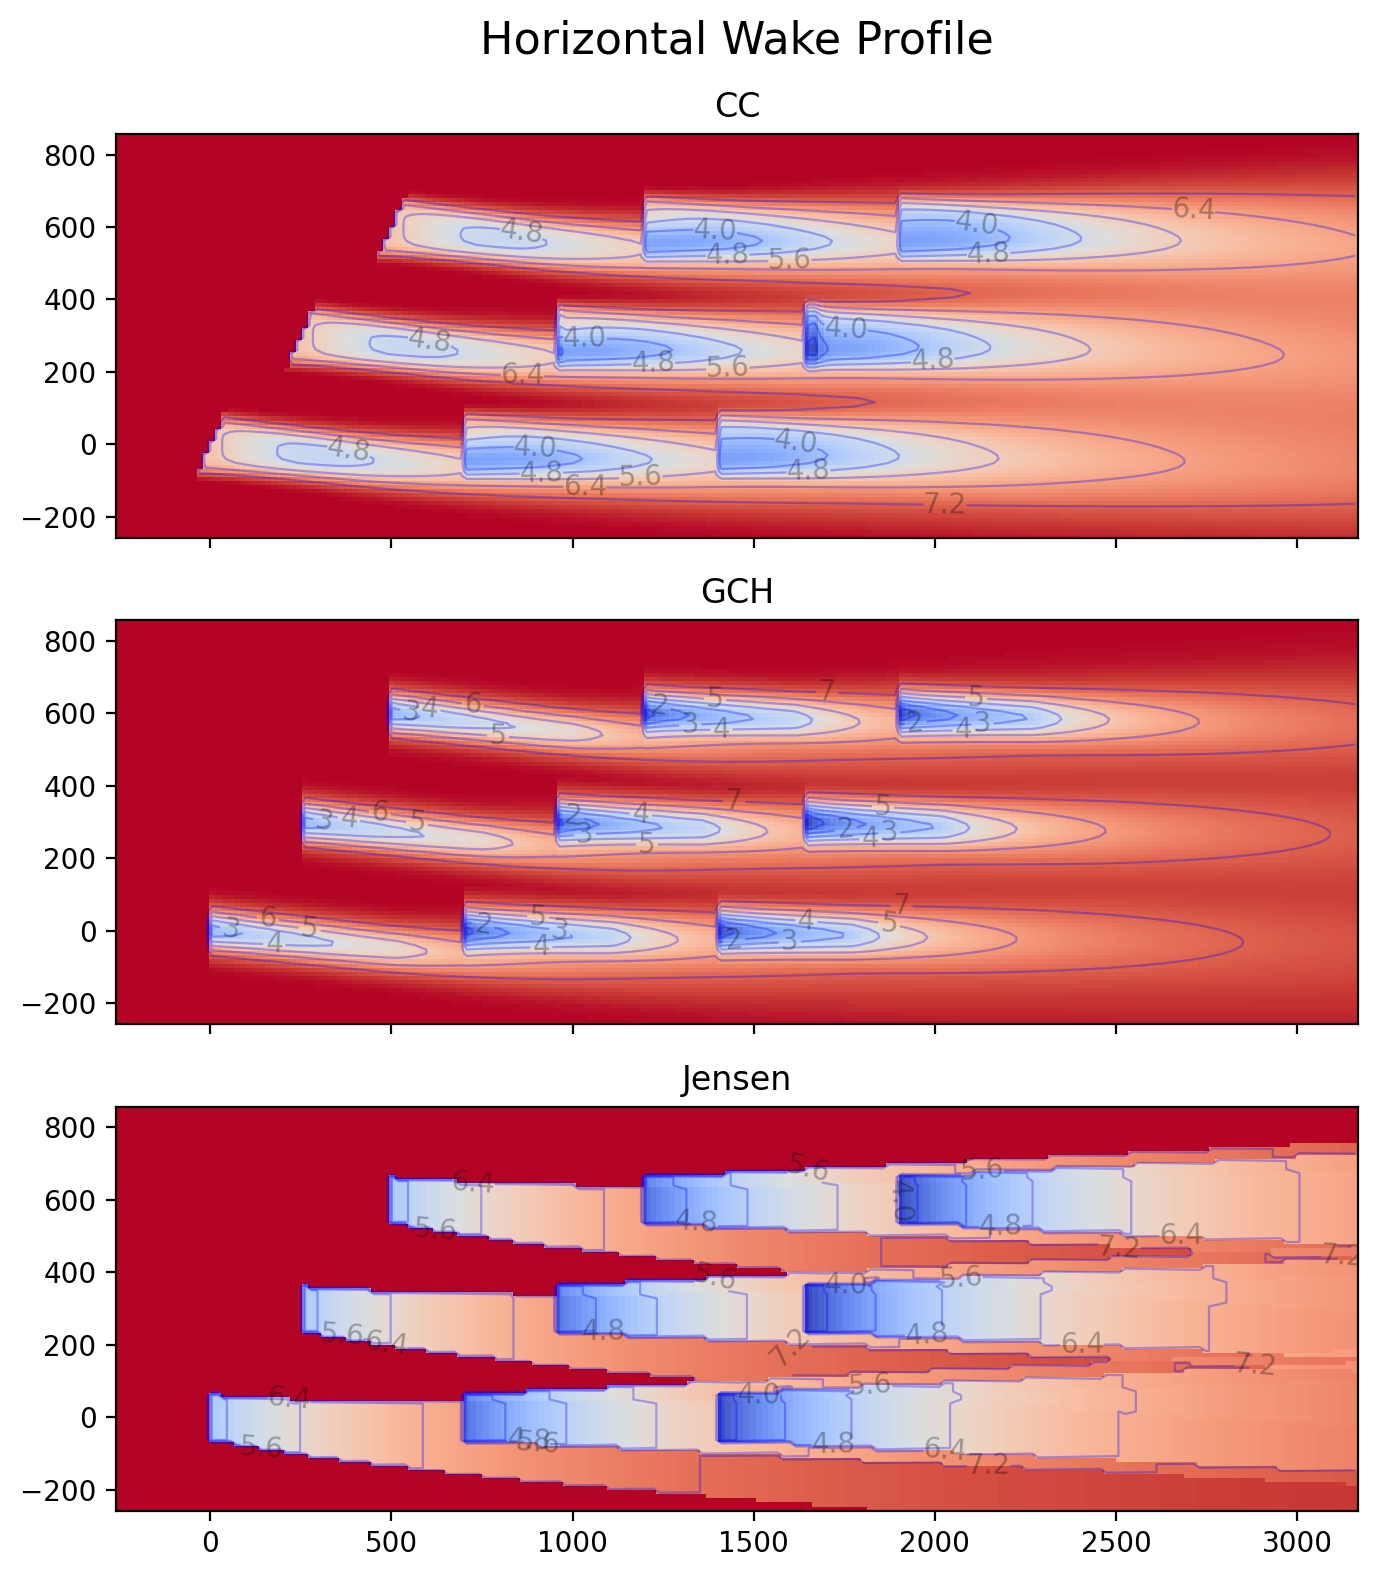

In [5]:
fig = plt.figure(figsize=(10, 8), dpi=200)
ax_list = fig.subplots(3, 1, sharex=True, sharey=True).flatten()

wakeviz.visualize_cut_plane(horizontal_cc, ax=ax_list[0])
wakeviz.visualize_cut_plane(horizontal_gch, ax=ax_list[1])
wakeviz.visualize_cut_plane(horizontal_jensen, ax=ax_list[2])

ax_list[0].set_title("CC", fontsize=12)
ax_list[1].set_title("GCH", fontsize=12)
ax_list[2].set_title("Jensen", fontsize=12)

fig.suptitle("Horizontal Wake Profile", fontsize=16)
fig.tight_layout()

In the below plots we show the turbine grids for each turbine.

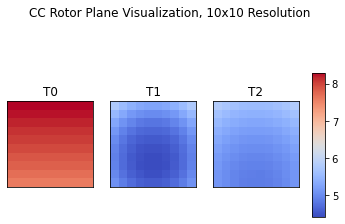

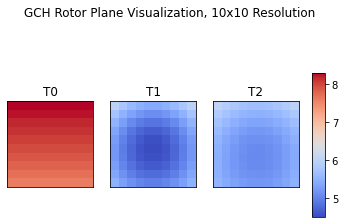

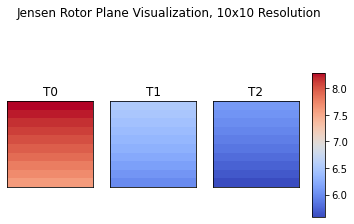

In [6]:
fig, axes, _ , _ = wakeviz.plot_rotor_values(
    fi_cc.floris.flow_field.u,
    wd_index=0,
    ws_index=0,
    n_rows=1,
    n_cols=3,
    return_fig_objects=True
)
fig.suptitle("CC Rotor Plane Visualization, 10x10 Resolution")
wakeviz.show_plots()

fig, axes, _ , _ = wakeviz.plot_rotor_values(
    fi_gch.floris.flow_field.u,
    wd_index=0,
    ws_index=0,
    n_rows=1,
    n_cols=3,
    return_fig_objects=True
)
fig.suptitle("GCH Rotor Plane Visualization, 10x10 Resolution")
wakeviz.show_plots()

fig, axes, _ , _ = wakeviz.plot_rotor_values(
    fi_jensen.floris.flow_field.u,
    wd_index=0,
    ws_index=0,
    n_rows=1,
    n_cols=3,
    return_fig_objects=True
)
fig.suptitle("Jensen Rotor Plane Visualization, 10x10 Resolution")
wakeviz.show_plots()